# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import skew

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, label_binarize, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectPercentile
from sklearn.multiclass import OneVsRestClassifier

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.utils.multiclass import type_of_target
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Loading Competition Data

In [2]:
train = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

In [3]:
train.head()



,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [4]:
train.tail()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
39206,2008-07-31,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,NaN,no
39207,2009-07-31,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,NaN,no
39208,2008-06-02,36,blue-collar,married,secondary,no,63,yes,no,NaN,56,8,-1,0,NaN,no
39209,2010-03-20,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,NaN,no
39210,2010-03-16,51,student,divorced,tertiary,yes,38594,yes,no,cellular,1877,19,780,148,success,yes


In [5]:
print('TRAIN DATA:', train.shape)
print('TEST DATA:', test.shape)

TRAIN DATA: (39211, 16)
TEST DATA: (10000, 15)


# **Exploratary Data Analysis**

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

- The dataset is a mixture of string and numerical datatypes need to transform accordingly

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  10000 non-null  object
 1   age                10000 non-null  int64 
 2   job                9941 non-null   object
 3   marital            10000 non-null  object
 4   education          9610 non-null   object
 5   default            10000 non-null  object
 6   balance            10000 non-null  int64 
 7   housing            10000 non-null  object
 8   loan               10000 non-null  object
 9   contact            7316 non-null   object
 10  duration           10000 non-null  int64 
 11  campaign           10000 non-null  int64 
 12  pdays              10000 non-null  int64 
 13  previous           10000 non-null  int64 
 14  poutcome           2492 non-null   object
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


In [8]:
train.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


 - data has wide age range (18-95) with mean age of 42 years

 - average of yearly balance is 5441 euros

 - median of contact duartion is 197 sec

### missing values

In [9]:
train.isna().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

4 columns have missing values in the dataset

- job
- education
- contact
- poutcome

lets see the percentage of missing values

In [10]:
null_val = []

for i in train.columns:
    if train[i].isna().sum() > 0:
        null_val.append(i)


for i in null_val:
    print(f'{i} Column has {train[i].isna().sum()/len(train) * 100} % missing values')
    print()

job Column has 0.5840197903649486 % missing values

education Column has 3.7412970850016576 % missing values

contact Column has 26.35995001402668 % missing values

poutcome Column has 75.10902552855066 % missing values



- poutcome column has more than 50% missing values, it could be removed

In [11]:
print(f'unique values in marital column are {train.marital.unique()}')
print(f'unique values in default column are {train.default.unique()}')
print(f'unique values in housing column are {train.housing.unique()}')
print(f'unique values in contact column are {train.contact.unique()}')
print(f'unique values in loan column are {train.loan.unique()}')

unique values in marital column are ['married' 'single' 'divorced']
unique values in default column are ['no' 'yes']
unique values in housing column are ['yes' 'no']
unique values in contact column are ['cellular' 'telephone' nan]
unique values in loan column are ['no' 'yes']


### last contact date

In [12]:
train['last contact date'].head()

0    2009-04-17
1    2009-10-11
2    2010-11-20
3    2009-09-01
4    2008-01-29
Name: last contact date, dtype: object

### age

In [13]:
train['age'].head()

0    26
1    52
2    44
3    33
4    31
Name: age, dtype: int64

In [14]:
train['age'].describe()

count    39211.000000
mean        42.120247
std         12.709352
min         18.000000
25%         33.000000
50%         40.000000
75%         50.000000
max         95.000000
Name: age, dtype: float64

In [15]:
skew(train['age'])

1.1242348167399974

-  column `age` is right skewed, shows more young individual in dataset

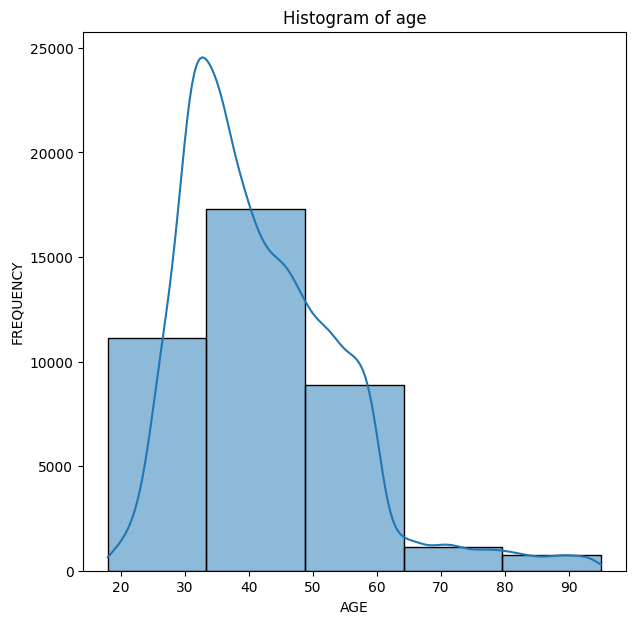

In [16]:
plt.figure(figsize=(7,7))
sns.histplot(train['age'], bins=5, kde = True, edgecolor = 'black')
plt.title('Histogram of age')
plt.xlabel("AGE")
plt.ylabel("FREQUENCY");

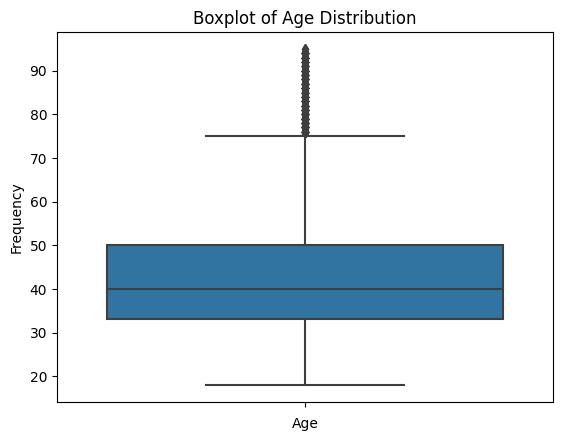

In [17]:
sns.boxplot(y=train['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Boxplot of Age Distribution')
plt.show()

### job

In [18]:
train['job'].unique()

array(['blue-collar', 'technician', 'admin.', 'entrepreneur',
       'unemployed', 'management', 'services', 'student', 'self-employed',
       'retired', 'housemaid', nan], dtype=object)

In [19]:
train['job'].head()

0     blue-collar
1      technician
2     blue-collar
3          admin.
4    entrepreneur
Name: job, dtype: object

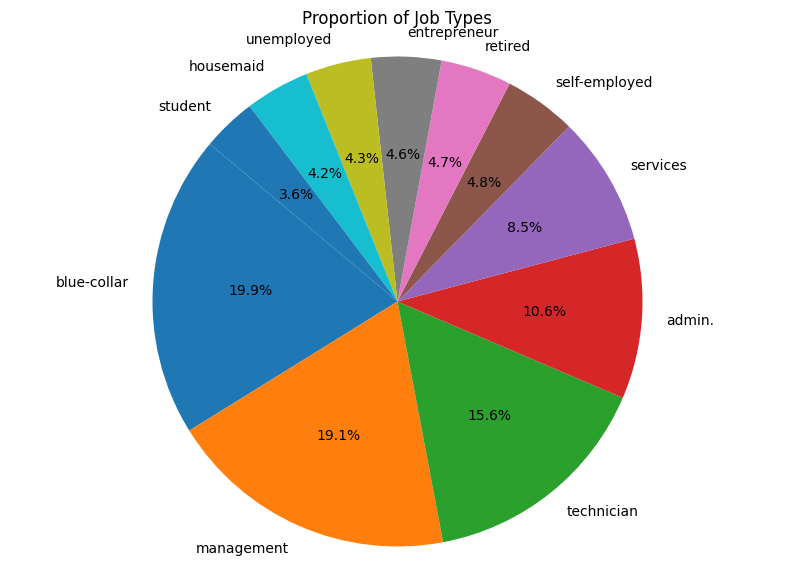

In [20]:
job_counts = train['job'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(job_counts, labels=job_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Job Types')
plt.axis('equal')
plt.show()


- mejority class in `job` column is blue-collar and management jobs.

### marital

In [21]:
train['marital'].head()

0    married
1    married
2    married
3    married
4     single
Name: marital, dtype: object

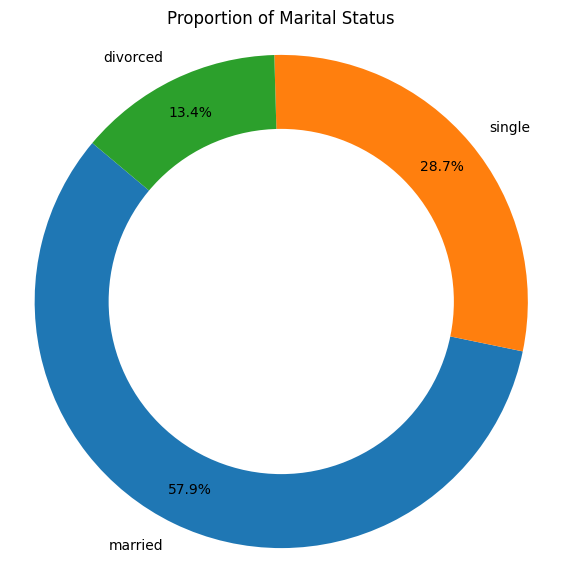

In [22]:
marital_counts = train['marital'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(marital_counts, labels=marital_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Proportion of Marital Status')
plt.axis('equal')
plt.show()

- mejority of people are married

### education

In [23]:
train['education'].head()

0    secondary
1    secondary
2    secondary
3    secondary
4     tertiary
Name: education, dtype: object

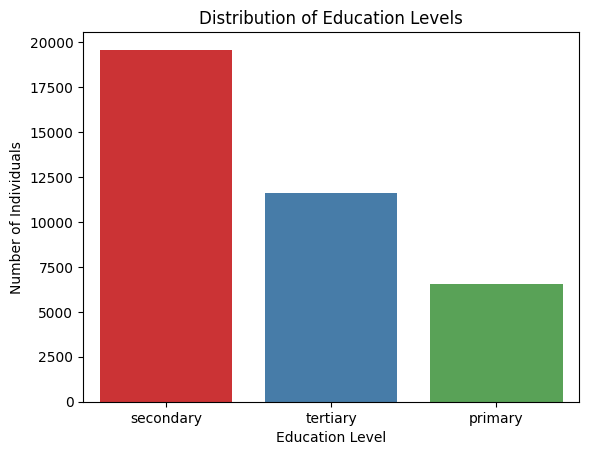

In [24]:
sns.countplot(x='education', data=train, palette='Set1')
plt.xlabel('Education Level')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Education Levels')
plt.show()


- Secondary Education (19,584) represents the largest group

### default

In [25]:
train['default'].head()

0    no
1    no
2    no
3    no
4    no
Name: default, dtype: object

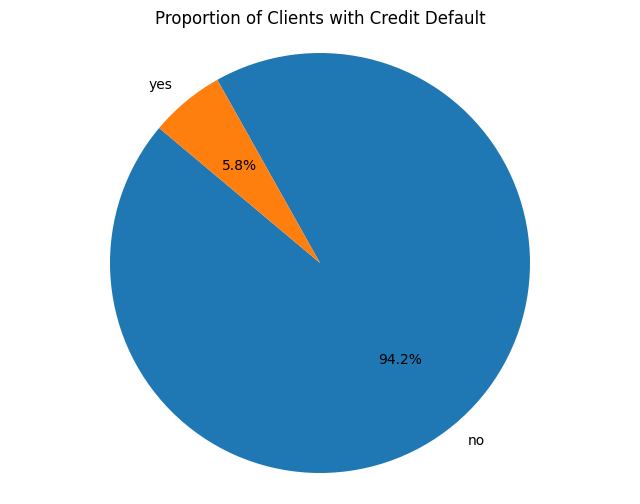

In [26]:
default_counts = train['default'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(default_counts, labels=default_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Clients with Credit Default')
plt.axis('equal')
plt.show()


### balance

In [27]:
train['balance'].head()

0     647
1     553
2    1397
3     394
4     137
Name: balance, dtype: int64

In [28]:
train['balance'].describe()

count     39211.000000
mean       5441.781719
std       16365.292065
min       -8019.000000
25%          98.000000
50%         549.000000
75%        2030.000000
max      102127.000000
Name: balance, dtype: float64

- balance is a int column and median average yearly balance 549 euros on the other hand max is 102127 euros

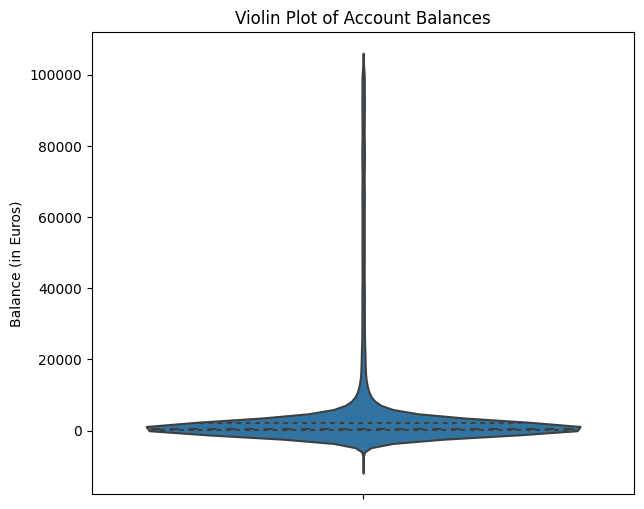

In [29]:
plt.figure(figsize=(7, 6))
sns.violinplot(y=train['balance'], inner='quartile')
plt.ylabel('Balance (in Euros)')
plt.title('Violin Plot of Account Balances')
plt.show()


### housing

In [30]:
train['housing'].head()

0    yes
1    yes
2     no
3    yes
4     no
Name: housing, dtype: object

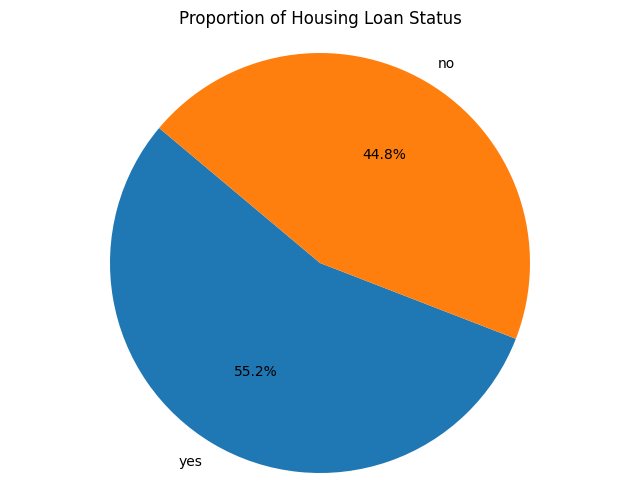

In [31]:
housing_counts = train['housing'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(housing_counts, labels=housing_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Housing Loan Status')
plt.axis('equal')
plt.show()


- more than half of the individuals have housing loan

### loan (personal loan)

In [32]:
train['loan'].head()

0    no
1    no
2    no
3    no
4    no
Name: loan, dtype: object

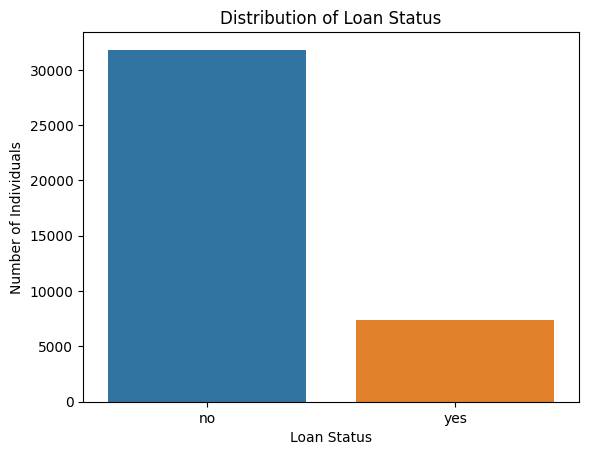

In [33]:

sns.countplot(x='loan', data=train)
plt.xlabel('Loan Status')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Loan Status')
plt.show()


- less individual with personal loan

### contact type

In [34]:
train['contact'].head()

0     cellular
1    telephone
2     cellular
3    telephone
4     cellular
Name: contact, dtype: object

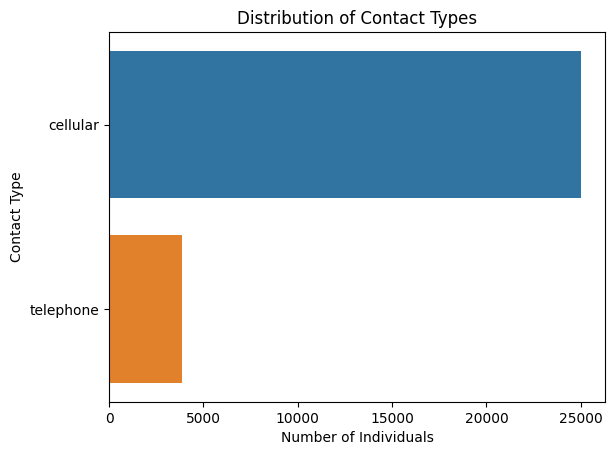

In [35]:
contact_counts = train['contact'].value_counts()

sns.barplot(x=contact_counts.values, y=contact_counts.index)
plt.ylabel('Contact Type')
plt.xlabel('Number of Individuals')
plt.title('Distribution of Contact Types')
plt.show()


### target

In [36]:
train['target'].head()

0    no
1    no
2    no
3    no
4    no
Name: target, dtype: object

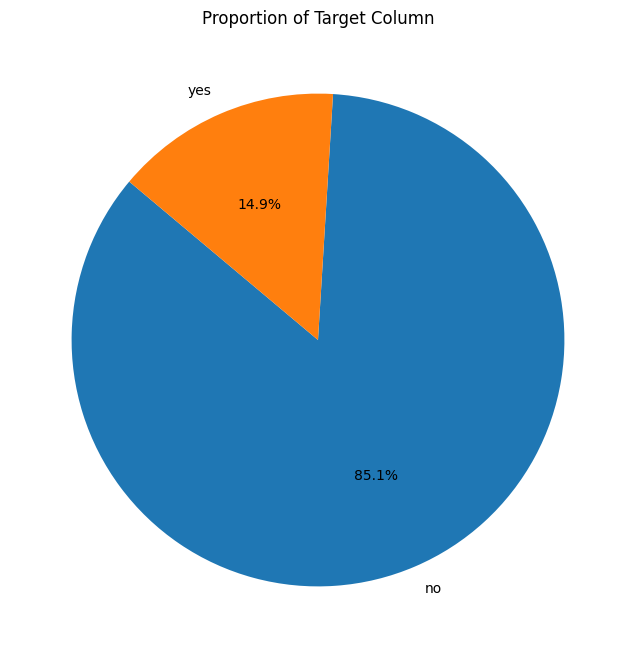

In [37]:
target_counts = train['target'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Target Column')
plt.show()


- looks like the data is highly imbalanced and biased towards "NO"

## Multivariate analysis

In [38]:
pd.crosstab(train['housing'], train['target'])

target,no,yes
housing,,
no,14049,3505
yes,19335,2322


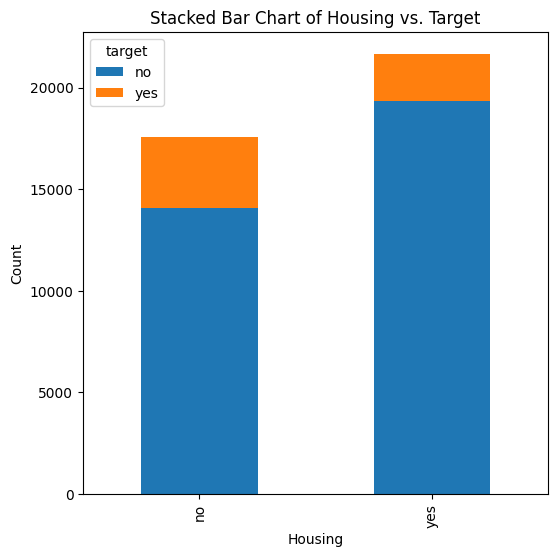

In [39]:
housing_target_ct = pd.crosstab(train['housing'], train['target'])
housing_target_ct.plot(kind='bar', stacked=True, figsize=(6, 6))
plt.xlabel('Housing')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Housing vs. Target')
plt.show()

- above stack bar chart shows the relationship between Housing loan and target columns.

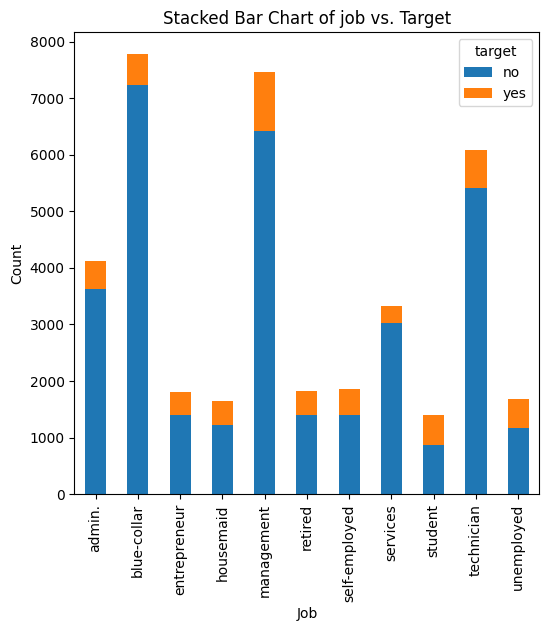

In [40]:
job_target_ct = pd.crosstab(train['job'], train['target'])
job_target_ct.plot(kind='bar', stacked=True, figsize=(6, 6))
plt.xlabel('Job')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of job vs. Target')
plt.show()

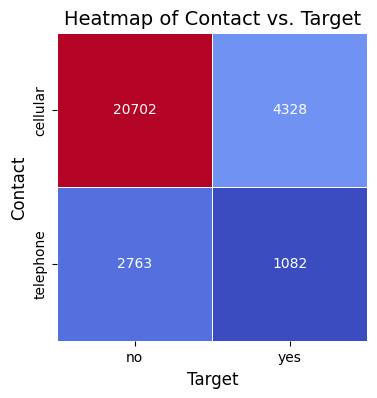

In [41]:
contact_target_ct = pd.crosstab(train['contact'], train['target'])

plt.figure(figsize=(4,4))
sns.heatmap(contact_target_ct, annot=True, cmap='coolwarm', fmt='d', cbar=False, linewidths=0.5)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Contact', fontsize=12)
plt.title('Heatmap of Contact vs. Target', fontsize=14)
plt.show()


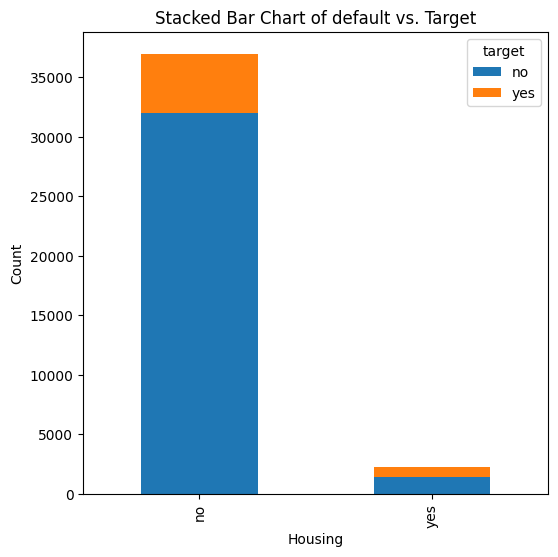

In [42]:
default_target_ct = pd.crosstab(train['default'], train['target'])
default_target_ct.plot(kind='bar', stacked=True, figsize=(6, 6))
plt.xlabel('Housing')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of default vs. Target')
plt.show()

### Marital Status vs Target

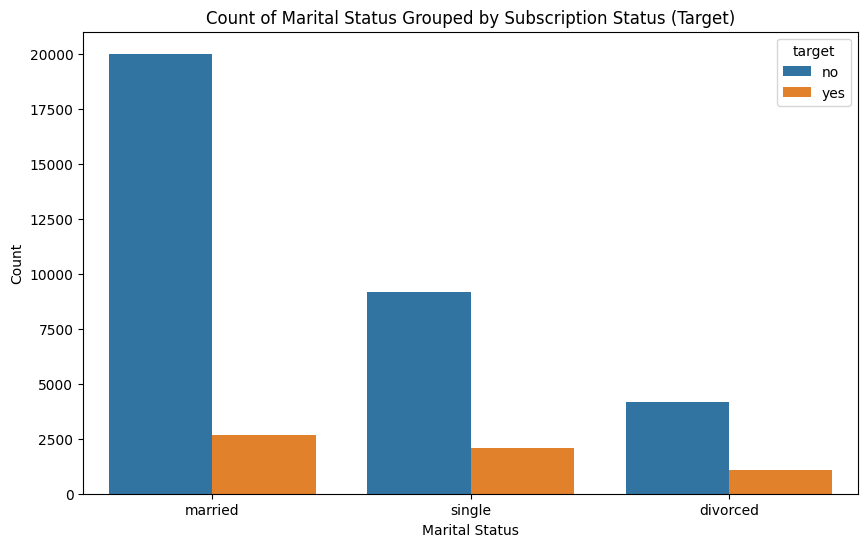

In [43]:
plt.figure(figsize=(10, 6))
sns.countplot(x='marital', hue='target', data=train)
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Count of Marital Status Grouped by Subscription Status (Target)')
plt.show()

- In all three categories married, single and divorced we can see that same trend, the subscription to term deposite is less in every category.

In [44]:
numeric_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
corr_matrix = train[numeric_features].corr()
print("Correlation Matrix for Numeric Features:")
corr_matrix


Correlation Matrix for Numeric Features:


,age,balance,duration,campaign,pdays,previous
age,1.000000,0.289150,0.255573,0.269439,0.199507,0.277487
balance,0.289150,1.000000,0.669737,0.674339,0.562097,0.716816
duration,0.255573,0.669737,1.000000,0.630944,0.527020,0.683951
campaign,0.269439,0.674339,0.630944,1.000000,0.519469,0.689211
pdays,0.199507,0.562097,0.527020,0.519469,1.000000,0.586175
previous,0.277487,0.716816,0.683951,0.689211,0.586175,1.000000


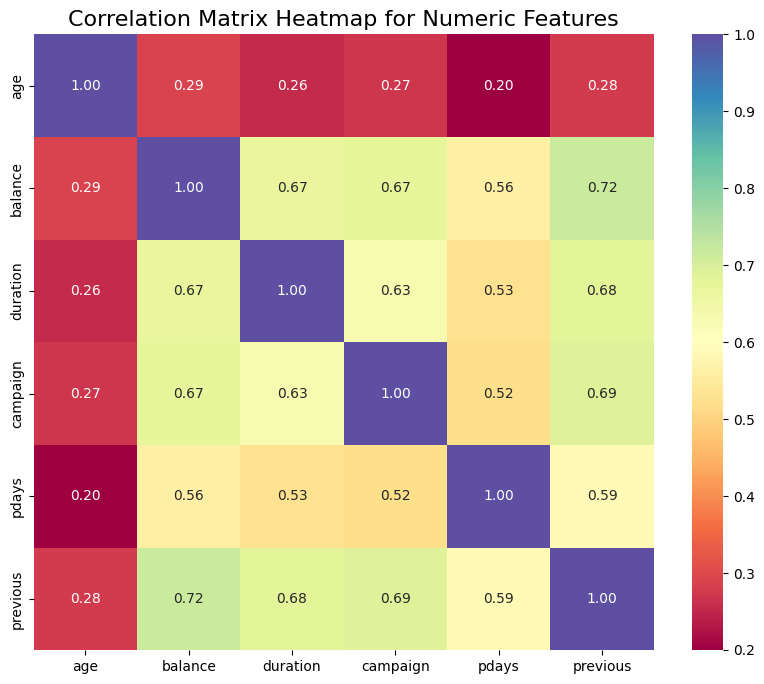

In [45]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Spectral", cbar=True)
plt.title('Correlation Matrix Heatmap for Numeric Features', fontsize=16)
plt.show()

- balance and previous has 72% correlation
- balance and campaign has 67% correlation
- balance and duration has 67% correlation
- previous and duration has 68% correlation

# Preprocessing

In [46]:
train['last contact date'] = pd.to_datetime(train['last contact date'])
test['last contact date'] = pd.to_datetime(test['last contact date'])
train['year'] = train['last contact date'].dt.year
train['month'] = train['last contact date' ].dt.month
train['weekday' ] = train['last contact date'].dt.weekday
test['year'] = test['last contact date'].dt.year
test['month'] = test['last contact date'].dt.month
test['weekday' ] = test['last contact date'].dt.weekday
train.drop(columns=['last contact date' ],inplace=True)
test.drop(columns=['last contact date'],inplace=True)

In [47]:
X = train.drop(columns=['target' ])
y = train['target']

In [48]:
type_of_target(y)

'binary'

In [49]:
columns = ['job', 'marital', 'education','default', 'housing', 'loan', 'contact', 'poutcome']

In [50]:

encoder_dict = {}
for i in columns:
    enc = LabelEncoder()
    X[i]= enc.fit_transform(X[i])
    test[i] = enc.transform(test[i])
    encoder_dict[i] = enc

In [51]:
# encoder_dict

In [52]:
cols = X.columns

i_imputer = IterativeImputer(random_state=0)

i_imputer = IterativeImputer()
X = i_imputer.fit_transform(X)
test = i_imputer.transform(test)

In [53]:
X = pd.DataFrame(X, columns=cols)
test = pd.DataFrame(test, columns=cols)

In [54]:
X

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,year,month,weekday
0,26.0,1.0,1.0,1.0,0.0,647.0,1.0,0.0,0.0,357.0,2.0,331.0,1.0,1.0,2009.0,4.0,4.0
1,52.0,9.0,1.0,1.0,0.0,553.0,1.0,0.0,1.0,160.0,1.0,-1.0,0.0,3.0,2009.0,10.0,6.0
2,44.0,1.0,1.0,1.0,0.0,1397.0,0.0,0.0,0.0,326.0,1.0,-1.0,0.0,3.0,2010.0,11.0,5.0
3,33.0,0.0,1.0,1.0,0.0,394.0,1.0,0.0,1.0,104.0,3.0,-1.0,0.0,3.0,2009.0,9.0,1.0
4,31.0,2.0,2.0,2.0,0.0,137.0,0.0,0.0,0.0,445.0,2.0,-1.0,0.0,3.0,2008.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,31.0,9.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,16.0,34.0,-1.0,0.0,3.0,2008.0,7.0,3.0
39207,59.0,0.0,1.0,0.0,0.0,6187.0,0.0,0.0,0.0,114.0,4.0,-1.0,0.0,3.0,2009.0,7.0,4.0
39208,36.0,1.0,1.0,1.0,0.0,63.0,1.0,0.0,2.0,56.0,8.0,-1.0,0.0,3.0,2008.0,6.0,0.0
39209,28.0,8.0,2.0,1.0,0.0,5916.0,0.0,0.0,0.0,93.0,5.0,-1.0,0.0,3.0,2010.0,3.0,5.0


In [55]:
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
y = pd.DataFrame(y, columns=['target'])

In [56]:
X.drop(columns=['year' ],inplace=True)
test.drop(columns=['year'], inplace=True)

In [57]:
x_train, x_test,y_train,y_test=train_test_split(X,y,train_size=0.8,stratify=y,random_state=0)

In [58]:
categorical_col = ['marital', 'housing', 'loan','default','weekday','contact', 'education','job', 'poutcome']
numerical_col = ['age','previous','pdays', 'duration','balance']

In [59]:
Transformer = ColumnTransformer([('scale',StandardScaler(), numerical_col),
                                ('encode', OneHotEncoder(), categorical_col) ], remainder='passthrough')



In [60]:
x_train_transformed = Transformer.fit_transform(x_train)
x_test_transformed = Transformer.transform(x_test)


# feature enginnering

In [61]:
# from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
# selector = SelectKBest(chi2,k=10)
# X_selected_train = selector.fit_transform(x_train_transformed,y_train)
# X_selected_test = selector.transform(x_test_transformed)

# X_selected_train = pd.DataFrame(X_selected_train,columns=X_train.columns[selector.get_support()])
# X_selected_test = pd.DataFrame(X_selected_val,columns=X_train.columns[selector.get_support()])

In [62]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import RFE
# model = LogisticRegression()
# rfe_selector = RFE(model,n_features_to_select=9)

# X_selected_train = rfe_selector.fit_transform(x_train_transformed,y_train)
# X_selected_test = rfe_selector.transform(x_test_transformed)
# X_selected_train = pd.DataFrame(X_selected_train,columns=x_train.columns[rfe_selector.get_support()])
# X_selected_test = pd.DataFrame(X_selected_val,columns=x_train.columns[rfe_selector.get_support()])

In [63]:

pca = PCA(n_components = 30)
X_train_pca = pca.fit_transform(x_train_transformed)
X_test_pca = pca.transform(x_test_transformed)

In [64]:
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

In [65]:
X_train_pca.shape

(31368, 30)

- not using X_train_pca beacure of low score

# Model Training

In [66]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=123)

def evaluate(y_test, pred):
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='micro'),3)*100))
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))

# LogReg

In [67]:
logreg = LogisticRegression(max_iter=2000)

cv_scores_logreg = cross_validate(logreg, x_train_transformed, y_train, cv=cv, n_jobs=-1, verbose=0, scoring='f1_micro', return_train_score=True)
pd.DataFrame(cv_scores_logreg, columns=['train_score','test_score'])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,train_score,test_score
0,0.860564,0.857667
1,0.858691,0.862608
2,0.858731,0.861970


- Will try some Hyperparameter tuining, to get the best params to train the models to increase accuracy.
- 
   Default solver lbfgs is taking much time to train, so instead we will try some fast learners.

### Hyperparameter tuining for logistic regression

In [68]:
# parameter tunning of model
logreg = LogisticRegression(max_iter=3000, penalty='l2', C=0.1)

params = {'solver': ['liblinear','newton-cg','sag'],
          'max_iter':[1000,2000]},

grid_search_log_reg = GridSearchCV(logreg, params, n_jobs=-1, verbose=1, cv=cv, scoring='f1_micro', return_train_score=True)
grid_search_log_reg.fit(x_train_transformed, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=123, test_size=0.2,
            train_size=None),
             estimator=LogisticRegression(C=0.1, max_iter=3000), n_jobs=-1,
             param_grid=({'max_iter': [1000, 2000],
                          'solver': ['liblinear', 'newton-cg', 'sag']},),
             return_train_score=True, scoring='f1_micro', verbose=1)

In [69]:
pd.DataFrame(grid_search_log_reg.cv_results_, columns=['params','mean_fit_time','mean_test_score','mean_train_score','rank_test_score']).sort_values(by='rank_test_score').set_index('params').head()

,mean_fit_time,mean_test_score,mean_train_score,rank_test_score
params,,,,
"{'max_iter': 1000, 'solver': 'newton-cg'}",1.078076,0.860536,0.859023,1
"{'max_iter': 1000, 'solver': 'sag'}",21.091420,0.860536,0.859063,1
"{'max_iter': 2000, 'solver': 'newton-cg'}",0.893183,0.860536,0.859023,1
"{'max_iter': 2000, 'solver': 'sag'}",16.596110,0.860536,0.859063,1
"{'max_iter': 1000, 'solver': 'liblinear'}",0.200940,0.860536,0.859063,5


- All the Solvers performed equally with score with regularization parameter value C=0.1 and penalty='l2'- 
But with respect to time taken for fitting the model the liblinearr' solver gives best results.

In [70]:
lr = LogisticRegression(max_iter=1000, penalty='l2', C=0.1, solver='liblinear')
lr.fit(x_train_transformed, y_train)
pred = lr.predict(x_test_transformed)

evaluate(y_test, pred)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy = 86.0%
F1 Score = 86.0%

 Confusiton Matrix:
 [[6487  190]
 [ 906  260]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      6677
           1       0.58      0.22      0.32      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.60      0.62      7843
weighted avg       0.83      0.86      0.83      7843



## Light GradientBoost

In [71]:
lgbm  = LGBMClassifier(max_depth = 20)

cv_scores_ridge = cross_validate(lgbm, x_train_transformed, y_train, cv=cv, n_jobs=-1, verbose=0, scoring='f1_micro', return_train_score=True)
pd.DataFrame(cv_scores_ridge, columns=['train_score','test_score'])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

,train_score,test_score
0,0.923049,0.872649
1,0.921575,0.868824
2,0.921934,0.866911


### **Hyperparameter tuining for Light Gradient Boost**

In [72]:
lgbm  = LGBMClassifier(max_depth = 20)

params = {
      'max_depth':[20,30,40]  # Test different maxdepth
}

grid_search_lgbm = GridSearchCV(lgbm, params, n_jobs=-1, verbose=1, cv=cv, scoring='f1_micro')
grid_search_lgbm.fit(x_train_transformed, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=123, test_size=0.2,
            train_size=None),
             estimator=LGBMClassifier(max_depth=20), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40]}, scoring='f1_micro',
             verbose=1)

In [73]:
pd.DataFrame(grid_search_lgbm.cv_results_, columns=['params','mean_fit_time','mean_test_score','mean_train_score','rank_test_score']).sort_values(by='rank_test_score').set_index('params').head()

,mean_fit_time,mean_test_score,mean_train_score,rank_test_score
params,,,,
{'max_depth': 20},1.717151,0.869461,NaN,1
{'max_depth': 30},1.593747,0.869461,NaN,1
{'max_depth': 40},1.162345,0.869461,NaN,1


In [74]:
lgbm  = LGBMClassifier(max_depth = 20)

lgbm.fit(x_train_transformed, y_train)
y_pred = lgbm.predict(x_test_transformed)

evaluate(y_test, y_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy = 87.0%
F1 Score = 87.0%

 Confusiton Matrix

# XGBoost

In [75]:
xgb  = XGBClassifier(max_depth = 5)

cv_scores_xgb = cross_validate(xgb, x_train_transformed, y_train, cv=cv, n_jobs=-1, verbose=0, scoring='f1_micro', return_train_score=True)
pd.DataFrame(cv_scores_xgb, columns=['train_score','test_score'])

,train_score,test_score
0,0.936519,0.872011
1,0.934925,0.868505
2,0.935164,0.870418


- the train score is high but test score is low classic case of over fitting so will perform hyperparameter tuining to get good params

 ### Hyperparameter tuining for xgb

In [76]:
xgb  = XGBClassifier(max_depth = 5)

params = {
      'max_depth':[5,7,10,15]  # Test different maxdepth
}

grid_search_xgb = GridSearchCV(xgb, params, n_jobs=-1, verbose=1, cv=cv, scoring='f1_micro')
grid_search_xgb.fit(x_train_transformed, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=123, test_size=0.2,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_p...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1, param_grid={'max_depth': [5, 7, 10, 15]},
             scoring='f1_micro', verbose=1)

In [77]:
pd.DataFrame(grid_search_xgb.cv_results_, columns=['params','mean_fit_time','mean_test_score','mean_train_score','rank_test_score']).sort_values(by='rank_test_score').set_index('params').head()

,mean_fit_time,mean_test_score,mean_train_score,rank_test_score
params,,,,
{'max_depth': 5},0.437003,0.870311,NaN,1
{'max_depth': 10},0.869611,0.869461,NaN,2
{'max_depth': 7},0.585576,0.868292,NaN,3
{'max_depth': 15},1.433400,0.866380,NaN,4


In [78]:
xgb  = XGBClassifier(max_depth = 5,scale_pos_weight=2)

xgb.fit(x_train_transformed, y_train)
y_pred = xgb.predict(x_test_transformed)

evaluate(y_test, y_pred)

Accuracy = 86.6%
F1 Score = 86.6%

 Confusiton Matrix:
 [[6010  667]
 [ 383  783]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      6677
           1       0.54      0.67      0.60      1166

    accuracy                           0.87      7843
   macro avg       0.74      0.79      0.76      7843
weighted avg       0.88      0.87      0.87      7843



# Model Comparison

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


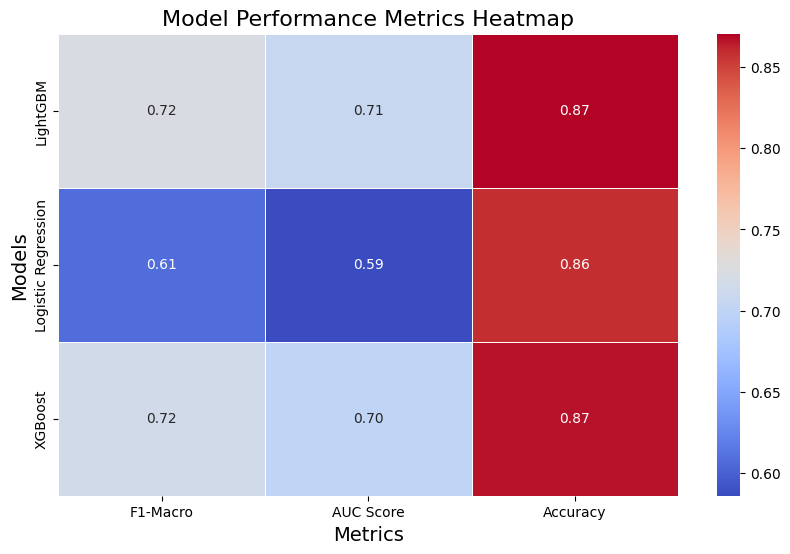

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# Model definitions (same as before)
model1 = LGBMClassifier(verbose=-1)
model2 = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
model3 = XGBClassifier()

models = [model1, model2, model3]
model_names = ['LightGBM', 'Logistic Regression', 'XGBoost']

f1_scores = []
auc_scores = []
accuracies = []

# Fit models and compute metrics
for model in models:
    model.fit(x_train_transformed, y_train)
    y_pred = model.predict(x_test_transformed)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    f1_scores.append(f1)
    auc_scores.append(auc)
    accuracies.append(accuracy)

# Create a DataFrame for heatmap
import pandas as pd

metrics_df = pd.DataFrame({
    'F1-Macro': f1_scores,
    'AUC Score': auc_scores,
    'Accuracy': accuracies
}, index=model_names)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)

# Add labels and title
plt.title('Model Performance Metrics Heatmap', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Models', fontsize=14)

plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


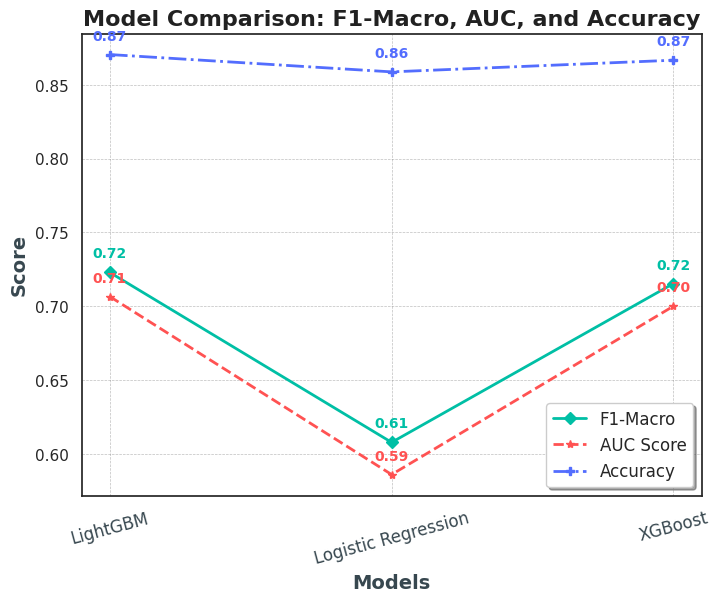

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# Model definitions (same as before)
model1 = LGBMClassifier(verbose=-1)
model2 = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
model3 = XGBClassifier()
# model4 = LinearSVC(dual=False, C=0.01, loss='squared_hinge', penalty='l2', max_iter=1000)


models = [model1, model2, model3]
model_names = ['LightGBM', 'Logistic Regression', 'XGBoost']

f1_scores = []
auc_scores = []
accuracies = []

# Fit models and compute metrics
for model in models:
    model.fit(x_train_transformed, y_train)
    y_pred = model.predict(x_test_transformed)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    f1_scores.append(f1)
    auc_scores.append(auc)
    accuracies.append(accuracy)

# Plotting
sns.set(style='white')
fig, ax = plt.subplots(figsize=(8,6))

# Line plot with new color palette and markers
ax.plot(model_names, f1_scores, marker='D', linestyle='-', label='F1-Macro', color='#00BFA5', linewidth=2)  # Teal
ax.plot(model_names, auc_scores, marker='*', linestyle='--', label='AUC Score', color='#FF5252', linewidth=2)  # Red
ax.plot(model_names, accuracies, marker='P', linestyle='-.', label='Accuracy', color='#536DFE', linewidth=2)  # Indigo

# Customize labels and title
ax.set_xlabel('Models', fontsize=14, color='#37474F', fontweight='bold')
ax.set_ylabel('Score', fontsize=14, color='#37474F', fontweight='bold')
ax.set_title('Model Comparison: F1-Macro, AUC, and Accuracy', fontsize=16, fontweight='bold', color='#212121')

# Legend with border and shadow
ax.legend(loc='lower right', fontsize=12, frameon=True, shadow=True, fancybox=True)

# Annotate each point
for i, model in enumerate(model_names):
    ax.text(i, f1_scores[i] + 0.01, f'{f1_scores[i]:.2f}', ha='center', fontsize=10, color='#00BFA5', fontweight='bold')
    ax.text(i, auc_scores[i] + 0.01, f'{auc_scores[i]:.2f}', ha='center', fontsize=10, color='#FF5252', fontweight='bold')
    ax.text(i, accuracies[i] + 0.01, f'{accuracies[i]:.2f}', ha='center', fontsize=10, color='#536DFE', fontweight='bold')

# Set x-ticks with rotation for better readability
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, fontsize=12, rotation=15, color='#37474F')

# Light background grid
ax.grid(color='gray', linestyle='dashed', linewidth=0.5, alpha=0.5)

plt.show()



# **Training on complete Dataset**

In [81]:
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report
model = XGBClassifier(scale_pos_weight=2)
model.fit(x_train_transformed,y_train)
print(classification_report(y_test,model.predict(x_test_transformed)))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      6677
           1       0.53      0.64      0.58      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.77      0.75      7843
weighted avg       0.87      0.86      0.87      7843



In [82]:
x_final_transformed = Transformer.transform(test)

In [83]:
y_pred = model.predict(x_final_transformed)
y_pred = label_enc.inverse_transform(y_pred)

In [84]:
y_pred

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

In [85]:
sub = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")
sub['target'] = y_pred
sub.to_csv("submission.csv",index=False)

# End